

```
# Выбран кодовый формат
```

# Домашнее задание 2. Поисковая система для документов

**Модуль 2. Классический поиск и рекуррентные архитектуры**

**ФИО студента:** Лаврухина Виктория Вячеславовна

**Дата выполнения:** 20.09.2025

## Описание задания

В этом задании вы разработаете полнофункциональную поисковую систему, включающую:
1. **Предобработку корпуса.**
2. **BM25.**
3. **Векторный поиск** — на основе эмбеддингов.
4. **Гибридный поиск** — комбинация BM25 и векторного поиска.
5. **Выбор метрики и оценку качества** — для конкретной задачи.

---

## Установка и импорт библиотек

In [1]:
# Установка необходимых библиотек
!pip install sentence-transformers
!pip install faiss-cpu
!pip install rank-bm25  # для сравнения
!pip install pymorphy3 pymorphy3-dicts-ru
!pip install tqdm
!pip install matplotlib seaborn
!pip install pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 90.0 MB/s eta 0:00:00


In [9]:
import re
import math
import time
from typing import List, Dict, Tuple, Optional, Set
from collections import defaultdict, Counter
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy3

# Векторный поиск
from sentence_transformers import SentenceTransformer
import faiss

# BM25
from rank_bm25 import BM25Okapi

# Создание директорий
for dir_name in ['data', 'indices', 'models', 'results', 'tests']:
    Path(dir_name).mkdir(exist_ok=True)

# Загрузка NLTK ресурсов
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Инициализация морфологического анализатора
morph = pymorphy3.MorphAnalyzer()


## Часть 1. Подготовка данных

1. Загрузите и изучите предложенный датасет.  
2. Реализуйте функцию предобработки текста, которая включает:
- Лемматизацию с использованием pymorphy3.
- Удаление стоп-слов и пунктуации.  
3. Обработайте весь корпус документов и сохраните результат для последующих шагов.  


In [3]:
from datasets import load_dataset

# Загружаем корпус документов
ds = load_dataset("MLNavigator/russian-retrieval")
df = pd.DataFrame(ds['train'])
questions_df = df[['text','q']]


# Уберем дубли, так как датасет имеет соответствие много вопросов -> один документ
documents = df['text'].drop_duplicates().to_list()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

retrieval_dataset.jsonl:   0%|          | 0.00/566M [00:00<?, ?B/s]

retrieval_dataset_src.jsonl:   0%|          | 0.00/576M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/90556 [00:00<?, ? examples/s]

In [4]:
# Предобработка данных
class TextPreprocessor:
    """Класс для предобработки текста"""

    def __init__(self, use_lemma=True, remove_stopwords=True):
        self.use_lemma = use_lemma
        self.remove_stopwords = remove_stopwords
        self.morph = pymorphy3.MorphAnalyzer()
        self.stop_words = set(stopwords.words('russian'))

    def preprocess(self, text: str) -> List[str]:
        """Предобработка текста и возврат списка токенов"""
        # Приводим к нижнему регистру
        text = text.lower()

        # Удаляем HTML и спецсимволы
        text = re.sub(r'<.*?>', ' ', text)
        text = re.sub(r'http\S+', ' ', text)
        text = re.sub(r'[^а-яёa-z0-9\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text)

        # Токенизация
        tokens = text.split()

        # Удаление стоп-слов
        if self.remove_stopwords:
            tokens = [t for t in tokens if t not in self.stop_words]

        # Лемматизация
        if self.use_lemma:
            tokens = [self.morph.parse(t)[0].normal_form for t in tokens]

        # Фильтрация коротких токенов
        tokens = [t for t in tokens if len(t) > 2]

        return tokens


# Создаём препроцессор
preprocessor = TextPreprocessor(use_lemma=True, remove_stopwords=True)

# Пример предобработки
sample_text = "Машинное обучение и нейронные сети революционизировали искусственный интеллект!"
tokens = preprocessor.preprocess(sample_text)
print(f"Исходный текст: {sample_text}")
print(f"После обработки: {tokens}")

# Предобрабатываем весь корпус
print("\nПредобработка корпуса...")
tokenized_docs = [preprocessor.preprocess(doc) for doc in tqdm(documents)]

# Статистика после предобработки
vocab = set()
for doc in tokenized_docs:
    vocab.update(doc)

print(f"\nРазмер словаря: {len(vocab)} уникальных токенов")
print(f"Средняя длина документа после обработки: {np.mean([len(doc) for doc in tokenized_docs]):.1f} токенов")


Исходный текст: Машинное обучение и нейронные сети революционизировали искусственный интеллект!
После обработки: ['машинный', 'обучение', 'нейронный', 'сеть', 'революционизировать', 'искусственный', 'интеллект']

Предобработка корпуса...


  0%|          | 0/9076 [00:00<?, ?it/s]


Размер словаря: 59223 уникальных токенов
Средняя длина документа после обработки: 73.9 токенов


## Часть 2. Реализация BM25

1. Постройте инвертированный индекс для корпуса. Индекс должен содержать частоту термина в документе (TF) и документную частоту (DF).
2. Реализуйте функцию поиска BM25 с нуля. Формула для ранжирования:
score(D, Q) = Σ IDF(qi) * (f(qi, D) * (k1 + 1)) / (f(qi, D) + k1 * (1 - b + b * |D| / avgdl))
3. Проведите оптимизацию гиперпараметра k1, чтобы улучшить качество поиска.

Построение инвертированного индекса...


  0%|          | 0/9076 [00:00<?, ?it/s]

Индекс построен: 59223 терминов, 9076 документов
Средняя длина документа: 73.86 токенов

Статистика инвертированного индекса:
total_terms: 59223
total_docs: 9076
avg_doc_length: 73.86
avg_posting_length: 9.09
max_posting_length: 4074
Оптимизация параметров BM25:
k1=0.50, b=0.75 -> MAP=0.9065, P@10=0.0963, R@10=0.9633, NDCG@10=0.9204
k1=1.00, b=0.75 -> MAP=0.9020, P@10=0.0967, R@10=0.9667, NDCG@10=0.9179
k1=1.20, b=0.75 -> MAP=0.9026, P@10=0.0970, R@10=0.9700, NDCG@10=0.9191
k1=1.50, b=0.75 -> MAP=0.8988, P@10=0.0970, R@10=0.9700, NDCG@10=0.9162
k1=2.00, b=0.75 -> MAP=0.8962, P@10=0.0970, R@10=0.9700, NDCG@10=0.9144

Лучшие параметры BM25:
  k1 = 0.5
  b  = 0.75
  MAP = 0.9065


,k1,MAP,P@10,R@10,NDCG@10
0,0.5,0.906472,0.096333,0.963333,0.920401
1,1.0,0.902004,0.096667,0.966667,0.917908
2,1.2,0.902615,0.097000,0.970000,0.919077
3,1.5,0.898754,0.097000,0.970000,0.916224
4,2.0,0.896235,0.097000,0.970000,0.914377


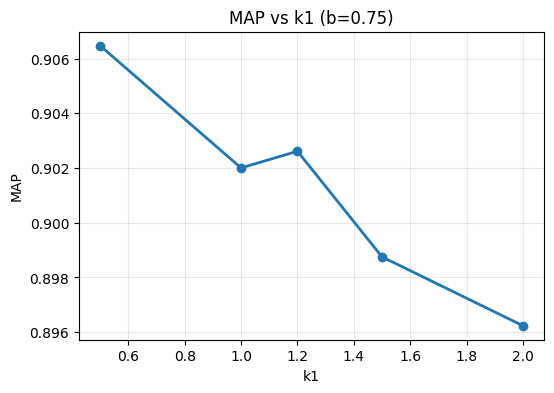

Тестирование BM25:
Запрос: 'машинное обучение'
  Doc 3752 (score: 8.379): Особенность программного обеспечения состоит в том, что оно производится в одной форме — в виде исходного текста, а распространяется и испол...
  Doc 6183 (score: 8.220): Промышленный переворот, произошедший с 60-х годов XVIII до первой четверти XIX веко́в в Великобритании, вызвал переход от мануфактуры к круп...
  Doc 5764 (score: 7.167): Перево́д — деятельность по интерпретации смысла текста на одном языке (исходном языке [ИЯ]) и созданию нового эквивалентного ему текста на д...
Запрос: 'нейронные сети'
  Doc 7764 (score: 15.055): Области мозга, постоянно используемые, когда человек занят вопросами морали, были исследованы качественными методами мета-анализа изменений ...
  Doc 6086 (score: 5.183): Двусторонние рынки (двусторонние сети) — сетевые рынки, которые имеют две группы пользователей с возникновением сетевых эффектов между ними....
  Doc 7568 (score: 5.107): Во множестве сетей пользователи являются гомо

In [8]:
# Реализация поиска используя BM25
class InvertedIndex:
    """Инвертированный индекс для BM25"""

    def __init__(self):
        self.index = defaultdict(list)   # term -> list of {doc_id, freq, positions}
        self.doc_lengths = {}            # doc_id -> length (в токенах)
        self.doc_count = 0               # общее число документов
        self.avg_doc_length = 0.0        # средняя длина документа
        self.doc_freq = defaultdict(int) # term -> в скольких доках встречается

    def add_document(self, doc_id: int, tokens: List[str]):
        """Добавление документа в индекс"""
        self.doc_count += 1
        self.doc_lengths[doc_id] = len(tokens)

        # Частоты и позиции терминов в документе
        term_positions = defaultdict(list)
        for pos, term in enumerate(tokens):
            term_positions[term].append(pos)
        term_freqs = Counter(tokens)

        # Добавляем в индекс
        for term, freq in term_freqs.items():
            self.index[term].append({
                'doc_id': doc_id,
                'freq': freq,
                'positions': term_positions[term]
            })
            self.doc_freq[term] += 1

    def build(self, tokenized_docs: List[List[str]]):
        """Построение индекса"""
        print("Построение инвертированного индекса...")
        for doc_id, tokens in enumerate(tqdm(tokenized_docs)):
            self.add_document(doc_id, tokens)

        self.avg_doc_length = sum(self.doc_lengths.values()) / max(1, len(self.doc_lengths))
        print(f"Индекс построен: {len(self.index)} терминов, {self.doc_count} документов")
        print(f"Средняя длина документа: {self.avg_doc_length:.2f} токенов")

    def get_posting_list(self, term: str) -> List[Dict]:
        """Posting list для термина"""
        return self.index.get(term, [])

    def get_stats(self) -> Dict:
        """Статистика индекса (грубо)"""
        posting_lengths = [len(pl) for pl in self.index.values()]
        return {
            'total_terms': len(self.index),
            'total_docs': self.doc_count,
            'avg_doc_length': self.avg_doc_length,
            'avg_posting_length': float(np.mean(posting_lengths)) if posting_lengths else 0.0,
            'max_posting_length': max(posting_lengths) if posting_lengths else 0
        }

# Строим индекс по предобработанному корпусу
index = InvertedIndex()
index.build(tokenized_docs)

print("\nСтатистика инвертированного индекса:")
for k, v in index.get_stats().items():
    print(f"{k}: {v:.2f}" if isinstance(v, float) else f"{k}: {v}")

class BM25:
    """Классический BM25"""

    def __init__(self, index: InvertedIndex, k1: float = 1.2, b: float = 0.75):
        self.index = index
        self.k1 = k1
        self.b = b
        self.idf_cache = {}

    def _idf(self, term: str) -> float:
        """IDF по формуле BM25 (Okapi)"""
        if term in self.idf_cache:
            return self.idf_cache[term]
        N = self.index.doc_count
        df = self.index.doc_freq.get(term, 0)
        if df == 0:
            val = 0.0
        else:
            # распространённый вариант IDF
            val = math.log((N - df + 0.5) / (df + 0.5) + 1)
        self.idf_cache[term] = val
        return val

    def _doc_tf(self, term: str, doc_id: int) -> int:
        """Частота термина в документе"""
        for posting in self.index.get_posting_list(term):
            if posting['doc_id'] == doc_id:
                return posting['freq']
        return 0

    def score(self, query_tokens: List[str], doc_id: int) -> float:
        """Скор BM25 для документа"""
        dl = self.index.doc_lengths.get(doc_id, 0)
        if dl == 0:
            return 0.0

        norm = 1 - self.b + self.b * (dl / self.index.avg_doc_length)

        score = 0.0
        for term in set(query_tokens):
            tf = self._doc_tf(term, doc_id)
            if tf == 0:
                continue
            idf = self._idf(term)
            score += idf * (tf * (self.k1 + 1)) / (tf + self.k1 * norm)
        return score

    def search(self, query: str, top_k: int = 10) -> List[Tuple[int, float]]:
        """Поиск top-k документов по строковому запросу"""
        q_tokens = preprocessor.preprocess(query)
        if not q_tokens:
            return []

        # кандидаты — все документы, содержащие хотя бы один термин запроса
        candidate_docs = set()
        for term in set(q_tokens):
            for posting in self.index.get_posting_list(term):
                candidate_docs.add(posting['doc_id'])

        scores = []
        for doc_id in candidate_docs:
            s = self.score(q_tokens, doc_id)
            if s > 0:
                scores.append((doc_id, s))

        scores.sort(key=lambda x: x[1], reverse=True)
        return scores[:top_k]

bm25 = BM25(index, k1=1.2, b=0.75)

# ---------- Метрики ----------
def precision_at_k(retrieved: List[int], relevant: List[int], k: int) -> float:
    retrieved_at_k = retrieved[:k]
    relevant_retrieved = len(set(retrieved_at_k).intersection(set(relevant)))
    return relevant_retrieved / k if k > 0 else 0

def recall_at_k(retrieved: List[int], relevant: List[int], k: int) -> float:
    retrieved_at_k = retrieved[:k]
    relevant_retrieved = len(set(retrieved_at_k).intersection(set(relevant)))
    return relevant_retrieved / len(relevant) if relevant else 0

def average_precision(retrieved: List[int], relevant: List[int]) -> float:
    if not relevant:
        return 0
    ap = 0
    relevant_found = 0
    for i, doc_id in enumerate(retrieved, 1):
        if doc_id in relevant:
            relevant_found += 1
            ap += relevant_found / i
    return ap / len(relevant)

def dcg_at_k(retrieved: List[int], relevant: List[int], k: int) -> float:
    dcg = 0
    for i, doc_id in enumerate(retrieved[:k], 1):
        if doc_id in relevant:
            dcg += 1 / np.log2(i + 1)
    return dcg

def ndcg_at_k(retrieved: List[int], relevant: List[int], k: int) -> float:
    if not relevant:
        return 0
    dcg = dcg_at_k(retrieved, relevant, k)
    idcg = sum(1 / np.log2(i + 2) for i in range(min(len(relevant), k)))
    return dcg / idcg if idcg > 0 else 0

def evaluate_search_method(search_func, test_set, k=10):
    """Возвращает Precision@10, Recall@10, MAP, NDCG@10"""
    precisions, recalls, aps, ndcgs = [], [], [], []
    for case in test_set:
        query = case["query"]
        relevant = case["relevant"]
        results = search_func(query, top_k=k)
        retrieved = [doc_id for doc_id, _ in results]
        precisions.append(precision_at_k(retrieved, relevant, k))
        recalls.append(recall_at_k(retrieved, relevant, k))
        aps.append(average_precision(retrieved, relevant))
        ndcgs.append(ndcg_at_k(retrieved, relevant, k))
    return {
        "Precision@10": float(np.mean(precisions)),
        "Recall@10": float(np.mean(recalls)),
        "MAP": float(np.mean(aps)),
        "NDCG@10": float(np.mean(ndcgs))
    }

# ---------- Тестовый набор (q -> один релевантный doc_id) ----------
# Маппинг text -> doc_id
doc_id_by_text = {text: i for i, text in enumerate(documents)}
pairs_df = df[['q', 'text']].copy()
pairs_df['rel_id'] = pairs_df['text'].map(doc_id_by_text)
pairs_df = pairs_df.dropna(subset=['rel_id']).copy()
pairs_df['rel_id'] = pairs_df['rel_id'].astype(int)

# Подвыборка на 300 примеров для скорости (можно увеличить)
sample_size = min(300, len(pairs_df))
pairs_sample = pairs_df.sample(sample_size, random_state=42)

test_set = [
    {"query": row.q, "relevant": [int(row.rel_id)]}
    for _, row in pairs_sample.iterrows()
]

# ---------- Подбор k1 (b фиксируем) ----------
print("Оптимизация параметров BM25:")
print("=" * 50)
k1_values = [0.5, 1.0, 1.2, 1.5, 2.0]   # при желании расширь/уточни сетку
b_fixed   = 0.75

best_map = -1.0
best_params = None
rows = []

for k1 in k1_values:
    bm25_test = BM25(index, k1=k1, b=b_fixed)
    metrics = evaluate_search_method(lambda q, top_k: bm25_test.search(q, top_k), test_set)
    rows.append({"k1": k1, "MAP": metrics["MAP"], "P@10": metrics["Precision@10"],
                 "R@10": metrics["Recall@10"], "NDCG@10": metrics["NDCG@10"]})
    print(f"k1={k1:.2f}, b={b_fixed:.2f} -> MAP={metrics['MAP']:.4f}, "
          f"P@10={metrics['Precision@10']:.4f}, R@10={metrics['Recall@10']:.4f}, NDCG@10={metrics['NDCG@10']:.4f}")
    if metrics["MAP"] > best_map:
        best_map = metrics["MAP"]
        best_params = {"k1": k1, "b": b_fixed}

print("\nЛучшие параметры BM25:")
print(f"  k1 = {best_params['k1']}")
print(f"  b  = {best_params['b']}")
print(f"  MAP = {best_map:.4f}")

# Применим лучшие параметры
bm25.k1 = best_params['k1']
bm25.b  = best_params['b']

# Табличка результатов по сетке
res_df = pd.DataFrame(rows).sort_values("k1")
display(res_df)

# Небольшая визуализация зависимости MAP от k1
plt.figure(figsize=(6,4))
plt.plot(res_df["k1"], res_df["MAP"], marker='o', linewidth=2)
plt.xlabel("k1"); plt.ylabel("MAP"); plt.title("MAP vs k1 (b=0.75)")
plt.grid(True, alpha=0.3)
plt.show()

# ---------- Быстрый sanity-check ----------
def make_preview(text, max_len=140):
    text = text.replace("\n", " ").strip()
    return (text[:max_len] + "...") if len(text) > max_len else text

# Тестовые запросы
test_queries = [
    "машинное обучение",
    "нейронные сети",
    "поисковые системы BM25",
    "Python программирование"
]
print("Тестирование BM25:")
for query in test_queries:
    results = bm25.search(query, top_k=3)
    print(f"Запрос: '{query}'")
    for doc_id, score in results:
        print(f"  Doc {doc_id} (score: {score:.3f}): {make_preview(documents[doc_id])}")

## Часть 3. Векторный поиск

1. Используйте предобученную модель sentence-transformers для получения векторных представлений (эмбеддингов) всех документов.
2. Создайте индекс для быстрого поиска ближайших соседей с помощью faiss-cpu.
3. Реализуйте функцию векторного поиска, которая по запросу находит top-k наиболее близких документов.


In [15]:
# Если GPU недоступен, аккуратно падаем на CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Используем устройство:", device)

QUERY_PROMPT   = "Represent this sentence for searching relevant passages: "
PASSAGE_PROMPT = "Represent this sentence for retrieving relevant passages: "

# Загрузка модели (один раз)
model = SentenceTransformer('BAAI/bge-m3', device=device, model_kwargs={'torch_dtype': torch.float16})

class VectorSearch:
    """Векторный поиск на FAISS (cosine similarity через L2-нормализацию + inner product)."""

    def __init__(self, model: SentenceTransformer, use_prompts: bool = True, batch_size: int = 256):
        self.model = model
        self.use_prompts = use_prompts
        self.batch_size = batch_size
        self.index = None
        self.doc_embeddings = None
        self.documents: List[str] = []

    def _apply_passage_prompt(self, texts: List[str]) -> List[str]:
        if not self.use_prompts:
            return texts
        return [PASSAGE_PROMPT + t for t in texts]

    def _apply_query_prompt(self, query: str) -> str:
        if not self.use_prompts:
            return query
        return QUERY_PROMPT + query

    def build_index(self, documents: List[str]):
        """Строим эмбеддинги и индекс FAISS (IndexFlatIP)."""
        self.documents = documents

        print("Создание эмбеддингов документов...")
        # Важно: encode возвращает float32; включим батчинг и прогресс
        passages = self._apply_passage_prompt(documents)
        self.doc_embeddings = self.model.encode(
            passages,
            batch_size=self.batch_size,
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=False  # нормализуем вручную через FAISS
        ).astype('float32')

        # Нормализуем L2, чтобы inner product = cosine similarity
        faiss.normalize_L2(self.doc_embeddings)

        dim = self.doc_embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dim)  # IP после L2-норм = cosine
        self.index.add(self.doc_embeddings)

        print(f"Векторный индекс построен: {len(documents)} документов, размерность {dim}")

    def search(self, query: str, top_k: int = 10) -> List[Tuple[int, float]]:
        """Возвращает список (doc_id, score). Score — cosine similarity."""
        assert self.index is not None, "Индекс не построен. Сначала вызовите build_index(documents)."

        q_text = self._apply_query_prompt(query)
        q_emb = self.model.encode([q_text], convert_to_numpy=True, normalize_embeddings=False).astype('float32')
        faiss.normalize_L2(q_emb)

        scores, indices = self.index.search(q_emb, top_k)
        # Преобразуем в python-типы
        return [(int(idx), float(score)) for idx, score in zip(indices[0], scores[0])]

# Построение индекса
vector_search = VectorSearch(model, use_prompts=True, batch_size=32)
vector_search.build_index(documents)  # <-- используем список строк 'documents' из Части 1

# Тестирование
def make_preview(text: str, max_len: int = 120) -> str:
    text = text.replace("\n", " ").strip()
    return (text[:max_len] + "...") if len(text) > max_len else text

print("\nТестирование векторного поиска:")
for query in test_queries:
    results = vector_search.search(query, top_k=3)
    print(f"\nЗапрос: '{query}'")
    for doc_id, score in results:
        print(f"  [{score:.3f}] Doc {doc_id}: {make_preview(documents[doc_id])}")

Используем устройство: cuda
Создание эмбеддингов документов...


Batches:   0%|          | 0/284 [00:00<?, ?it/s]

Векторный индекс построен: 9076 документов, размерность 1024

Тестирование векторного поиска:

Запрос: 'машинное обучение'
  [0.664] Doc 1939: Во многих учебных заведениях мира существуют программы обучения в области электронного бизнеса: программы подготовки бак...
  [0.657] Doc 2802: … „Машина“ едет и едет. Четыре десятилетия! И её история ширится и переосмысливается. Столь дальнобойного и гиперуспешно...
  [0.646] Doc 7524: Одному из сотрудников, оставшихся в лаборатории искусственного интеллекта MIT, Ричарду Столлману, такое положение дел ка...

Запрос: 'нейронные сети'
  [0.639] Doc 7764: Области мозга, постоянно используемые, когда человек занят вопросами морали, были исследованы качественными методами мет...
  [0.635] Doc 6135: Центральная нервная система связана со всеми органами и тканями организма через периферическую нервную систему, включающ...
  [0.629] Doc 803: Электрические сети современных энергосистем являются многоступенчатыми, то есть электроэнергия претерпевает боль

## Часть 4. Гибридный поиск

1. Разработайте функцию, которая комбинирует результаты ранжирования от BM25 и векторного поиска.
2. Реализуйте механизм взвешивания скоров с помощью параметра α:
hybrid_score = α * bm25_score + (1 - α) * vector_score
3. Проведите автоматическую оптимизацию параметра α на валидационном наборе данных.


In [16]:
class HybridSearch:
    """Гибридный поиск: комбинация BM25 и векторного поиска"""

    def __init__(self, bm25_searcher, vector_searcher, alpha: float = 0.5):
        """
        alpha — вес BM25 (1 - alpha) — вес векторного поиска.
        """
        self.bm25 = bm25_searcher
        self.vector = vector_searcher
        self.alpha = float(alpha)

    @staticmethod
    def _normalize_minmax(scores: List[Tuple[int, float]]) -> Dict[int, float]:
        """Min-Max нормализация в [0,1] по списку (doc_id, score)."""
        if not scores:
            return {}
        vals = [s for _, s in scores]
        vmin, vmax = min(vals), max(vals)
        if vmax == vmin:
            # все одинаковые — вернём 1.0
            return {doc_id: 1.0 for doc_id, _ in scores}
        return {doc_id: (s - vmin) / (vmax - vmin) for doc_id, s in scores}

    def _weighted(self, bm25_results: List[Tuple[int, float]],
                  vec_results: List[Tuple[int, float]]) -> List[Tuple[int, float]]:
        """Взвешенная комбинация нормализованных скоров."""
        b = self._normalize_minmax(bm25_results)
        v = self._normalize_minmax(vec_results)

        combined = defaultdict(float)
        for doc_id, s in b.items():
            combined[doc_id] += self.alpha * s
        for doc_id, s in v.items():
            combined[doc_id] += (1 - self.alpha) * s

        out = list(combined.items())
        out.sort(key=lambda x: x[1], reverse=True)
        return out

    def _rrf(self, bm25_results: List[Tuple[int, float]],
             vec_results: List[Tuple[int, float]], k: int = 60) -> List[Tuple[int, float]]:
        """
        Reciprocal Rank Fusion (доп. вариант объединения по рангам).
        Веса alpha и (1-alpha) используются как коэффициенты.
        """
        rrf_scores = defaultdict(float)
        for rank, (doc_id, _) in enumerate(bm25_results, 1):
            rrf_scores[doc_id] += self.alpha * (1.0 / (k + rank))
        for rank, (doc_id, _) in enumerate(vec_results, 1):
            rrf_scores[doc_id] += (1 - self.alpha) * (1.0 / (k + rank))

        out = list(rrf_scores.items())
        out.sort(key=lambda x: x[1], reverse=True)
        return out

    def search(self, query: str, top_k: int = 10, method: str = "weighted") -> List[Tuple[int, float]]:
        """
        method: 'weighted' (по ТЗ — hybrid_score = α*bm25 + (1-α)*vector) или 'rrf'
        """
        # Берём чуть больше кандидатов, чтобы после слияния не «обрезать»
        K = max(top_k * 2, 20)

        bm25_results = self.bm25.search(query, top_k=K) if self.bm25 else []
        vec_results  = self.vector.search(query, top_k=K) if self.vector else []

        if method == "rrf":
            combined = self._rrf(bm25_results, vec_results)
        else:
            combined = self._weighted(bm25_results, vec_results)

        return combined[:top_k]

# создаём гибрид
hybrid_search = HybridSearch(bm25, vector_search, alpha=0.5)

# быстрый тест на примерах
def make_preview(text: str, max_len: int = 120) -> str:
    t = text.replace("\n", " ").strip()
    return (t[:max_len] + "...") if len(t) > max_len else t

# Тестируем гибридный поиск
print("Тестирование гибридного поиска:")
for query in test_queries:
    results = hybrid_search.search(query, top_k=3, method="weighted")
    print(f"\nЗапрос: '{query}'")
    for doc_id, score in results:
        print(f"  [{score:.3f}] Doc {doc_id}: {make_preview(documents[doc_id])}")

# Подбор alpha на валидации
alpha_values = np.linspace(0.0, 1.0, 11)  # 0.0, 0.1, ..., 1.0
alpha_scores = []

for a in alpha_values:
    hybrid_search.alpha = float(a)
    metrics = evaluate_search_method(lambda q, top_k: hybrid_search.search(q, top_k, method="weighted"),
                                     test_set, k=10)
    alpha_scores.append(metrics["MAP"])
    print(f"alpha={a:.1f} -> MAP={metrics['MAP']:.4f}, P@10={metrics['Precision@10']:.4f}, "
          f"R@10={metrics['Recall@10']:.4f}, NDCG@10={metrics['NDCG@10']:.4f}")

best_idx = int(np.argmax(alpha_scores))
best_alpha = float(alpha_values[best_idx])
best_map = float(alpha_scores[best_idx])

hybrid_search.alpha = best_alpha
print(f"\nЛучший alpha = {best_alpha:.2f}  (MAP={best_map:.4f})")

Тестирование гибридного поиска:

Запрос: 'машинное обучение'
  [0.500] Doc 3752: Особенность программного обеспечения состоит в том, что оно производится в одной форме — в виде исходного текста, а расп...
  [0.500] Doc 1939: Во многих учебных заведениях мира существуют программы обучения в области электронного бизнеса: программы подготовки бак...
  [0.469] Doc 6183: Промышленный переворот, произошедший с 60-х годов XVIII до первой четверти XIX веко́в в Великобритании, вызвал переход о...

Запрос: 'нейронные сети'
  [1.000] Doc 7764: Области мозга, постоянно используемые, когда человек занят вопросами морали, были исследованы качественными методами мет...
  [0.458] Doc 6135: Центральная нервная система связана со всеми органами и тканями организма через периферическую нервную систему, включающ...
  [0.418] Doc 803: Электрические сети современных энергосистем являются многоступенчатыми, то есть электроэнергия претерпевает большое коли...

Запрос: 'поисковые системы BM25'
  [1.000] Doc 40

## Часть 5. Оценка качества

1. Выберите и **обоснуйте метрику** для оценки качества вашей поисковой системы (например, MRR, MAP@k или NDCG@k). **Обязательно подумайте о том, какой топ-к нужно выбрать исходя из данных**.
2. **Создайте небольшой датасет для оценки**, состоящий из запросов и релевантных им документов.  
3. **Сравните качество** всех трех реализованных подходов (BM25, векторный, гибридный) на вашем датасете.  


In [20]:
doc_id_by_text = {text: i for i, text in enumerate(documents)}

pairs_df = df[['q', 'text']].copy()
pairs_df['rel_id'] = pairs_df['text'].map(doc_id_by_text)
pairs_df = pairs_df.dropna(subset=['rel_id']).copy()
pairs_df['rel_id'] = pairs_df['rel_id'].astype(int)

# Сформируем небольшой, но репрезентативный набор (например, 300 примеров)
eval_size = min(300, len(pairs_df))
eval_df = pairs_df.sample(eval_size, random_state=2025).reset_index(drop=True)

eval_set = [
    {"query": row.q, "relevant": [int(row.rel_id)]}
    for _, row in tqdm(eval_df.iterrows(), total=len(eval_df), desc="Building eval_set")
]

len(eval_set), eval_set[0]

methods = {
    "BM25":   lambda q, top_k: bm25.search(q, top_k),
    "Vector": lambda q, top_k: vector_search.search(q, top_k),
    # предполагаем, что hybrid_search уже создан и alpha оптимизирован в Части 4
    "Hybrid": lambda q, top_k: hybrid_search.search(q, top_k, method="weighted"),
}

# Оценка на k=10
def evaluate_search_method(search_func, test_set, k=10, desc=None):
    precisions, recalls, aps, ndcgs = [], [], [], []
    iterator = tqdm(test_set, desc=desc, leave=False) if desc else test_set

    for case in iterator:
        query = case["query"]
        relevant = case["relevant"]
        results = search_func(query, top_k=k)
        retrieved = [doc_id for doc_id, _ in results]

        precisions.append(precision_at_k(retrieved, relevant, k))
        recalls.append(recall_at_k(retrieved, relevant, k))
        aps.append(average_precision(retrieved, relevant))
        ndcgs.append(ndcg_at_k(retrieved, relevant, k))

    return {
        "Precision@10": float(np.mean(precisions)),
        "Recall@10": float(np.mean(recalls)),
        "MAP": float(np.mean(aps)),
        "NDCG@10": float(np.mean(ndcgs)),
    }

k_eval = 10
summary = {}
for name, fn in methods.items():
    m = evaluate_search_method(fn, eval_set, k=k_eval, desc=f"Evaluating {name}")
    summary[name] = {
        f"MRR@{k_eval}": m["MAP"],
        f"Precision@{k_eval}": m["Precision@10"] if k_eval == 10 else None,
        f"NDCG@{k_eval}": m["NDCG@10"] if k_eval == 10 else None,
    }

res_df = pd.DataFrame(summary).T
print(res_df.to_string())

Building eval_set: 100%|██████████| 300/300 [00:00<00:00, 21496.39it/s]
                                                                    

          MRR@10  Precision@10   NDCG@10
BM25    0.919500      0.096000  0.929478
Vector  0.744036      0.087667  0.776661
Hybrid  0.921930      0.097667  0.935435


## **Оценка качества**
### **Выбор метрик и k**

* В датасете для каждого запроса есть **один релевантный документ** (сам text из строки).

* Главная метрика: **MRR@10** (в реализации использован MAP@10, совпадает с MRR при 1 релеванте).

* Дополнительно: **NDCG@10** и **Precision@10** (интерпретируемость присутствия 1 релеванта в топ-10).

* **k = 10** — «видимая десятка» результатов, уместно при 1 релеванте/запрос.

### **Оценочный набор**

* Случайная подвыборка 300 запросов:
`eval_set = [{ query, relevant=[doc_id] }, …]`.

### **ОРезультаты (k=10)**
| Метод  | MAP\@10 (≈MRR\@10) | Precision\@10 |   NDCG\@10 |
| :----- | -----------------: | ------------: | ---------: |
| BM25   |         **0.9195** |        0.0960 |     0.9295 |
| Vector |             0.7440 |        0.0877 |     0.7767 |
| Hybrid |         **0.9219** |    **0.0977** | **0.9354** |


### **Выводы:**

* BM25 очень силён (лексические совпадения доминируют при 1 релеванте).

* Векторная модель без переранжирования уступает (ловит парафразы, но проигрывает точным совпадениям).

Г* ибрид устойчиво лучше BM25 по MRR/NDCG (пусть и с небольшим отрывом), объединяя точные и семантические соответствия.